In [45]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import building_blocks as lrb
import matplotlib.pyplot as plt


In [46]:
# Set seed for reproducibility
np.random.seed(6)

### Logistic Regression Feature Selection Example.

In [47]:
# Number of samples
n = 1010

# Generate 2 features.
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)

# True logistic model only depends on X1 and X2
logits = 1.0 * X1 + 0.2 * X2     # no contribution from X3

# Convert to probabilities
probs = 1 / (1 + np.exp(-logits))

# Sample binary labels
y = np.random.binomial(1, probs)

# Combine into a DataFrame
df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'y': y
})

# Dataframe preview
print(df.head())

         X1        X2  y
0 -0.311784 -0.873722  0
1  0.729004  0.070111  1
2  0.217821  0.096106  0
3 -0.899092 -0.471893  0
4 -2.486781 -0.101309  0


In [48]:
# Define feature combinations to test
feature_sets = [
    ['X1'],          
    ['X1', 'X2'],    
    ['X2'],          
]

# Fit models and calculate AIC
results = []
for features in feature_sets:
    # Fit model
    X = df[features]
    model = LogisticRegression()
    model.fit(X, y)
    
    # Calculate AIC
    y_pred = model.predict_proba(X)
    n_params = len(features) + 1  # +1 for intercept
    aic = 2 * n_params + 2 * log_loss(y, y_pred) * n
    

    results.append({
        'features': ', '.join(features),
        'AIC': aic,
        'coefficients': dict(zip(features, model.coef_[0]))
    })

In [49]:
# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['features', 'AIC']].sort_values('AIC'))

print("\nCoefficients for best model:")
best_model = results_df.loc[results_df['AIC'].idxmin()]
print(best_model['coefficients'])



Model Comparison:
  features          AIC
1   X1, X2  1271.039380
0       X1  1277.978882
2       X2  1399.039407

Coefficients for best model:
{'X1': 0.8175890132110244, 'X2': 0.20820488268137052}


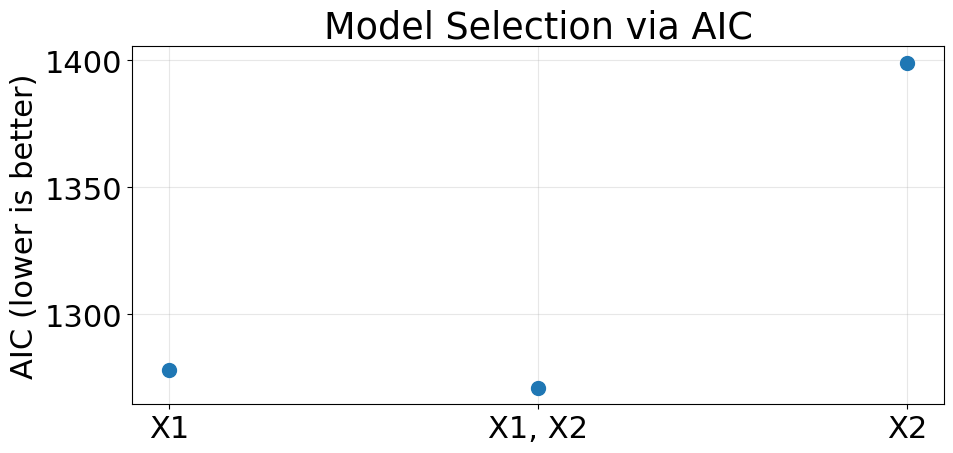

In [50]:
# Visualize AIC scores as dot plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(results)), results_df['AIC'], 'o', markersize=10)
plt.xticks(range(len(results)), results_df['features'])
plt.ylabel('AIC (lower is better)')
plt.title('Model Selection via AIC')
plt.grid(True, alpha=0.3)
plt.rcParams.update({'font.size': 22})
plt.xticks(range(len(results)), results_df['features'], fontsize=22)
plt.tight_layout()
plt.show()

In [51]:
Xall = df[['X1','X2']]
Xall = Xall.to_numpy()

In [ ]:
# compute the influence scores for each point.
# drop points with the top aN influence scores.
# observe if the aic ranking is robust to the deletion of these points.

In [69]:
model_full = lrb.run_logistic_regression(Xall, y)
model_full.coef_
# compute predicted probabilities.
p_hats = model_full.predict_proba(Xall)
pos_p_hats = p_hats[:,1]

In [73]:
# Compute influence scores for all outlier points
scores = []
# compute the influence scores for all points.
for ind in range(1, 1010):
    score_i = lrb.compute_approx(pos_p_hats, Xall, ind, y, "1sN")
    scores.append(score_i)

In [74]:
# sort indices in ascending order.
inds = np.argsort(scores)
# MIS. identify the points with the most negative (direction chosen arbitrarily) scores.
print(f'the indices of the points with the most negative scores are: {inds[-10:]}')

the indices of the points with the most negative scores are: [551 190 575 361 650 206 419 584 425 664]


In [75]:
# sort scores by inds
sorted_scores = np.array(scores)[inds]
print(f'the most negative scores are {sorted_scores[:10]}')
print(f'the most positive scores are {sorted_scores[-10:]}')

the most negative scores are [-0.01652962 -0.01642306 -0.01074982 -0.01013197 -0.0099474  -0.00964353
 -0.00933511 -0.0087062  -0.0085704  -0.00851998]
the most positive scores are [0.00243617 0.00244268 0.00244982 0.00253478 0.00258583 0.00259297
 0.00261535 0.00262032 0.00272875 0.0027515 ]


In [61]:
# Get indices of points to keep (all except most negative scores)
# remove the first 10 indices.
# X_reduced = np.delete(Xall, inds[:10], axis=0)
# y_reduced = np.delete(y, inds[:10])
# remove the last 10 indices.
X_reduced = np.delete(Xall, inds[-10:], axis=0)
y_reduced = np.delete(y, inds[-10:])

In [62]:
# Combine into a DataFrame
df_reduced = pd.DataFrame({
    'X1': X_reduced[:,0],
    'X2': X_reduced[:,1],
    'y': y_reduced
})

# Dataframe preview
print(df_reduced.shape)

(1000, 3)


In [65]:
# Define feature combinations to test
feature_sets = [
    ['X1'],           # True model
    ['X1', 'X2'],     # Model with noise feature
    ['X2'],           # Incorrect model
]

# Fit models and calculate AIC
results = []
for features in feature_sets:
    # Fit model
    X_reduced = df_reduced[features]
    model = LogisticRegression()
    model.fit(X_reduced, y_reduced)
    
    # Calculate AIC
    y_pred = model.predict_proba(X_reduced)
    n_params = len(features) + 1  # +1 for intercept
    aic = 2 * n_params + 2 * log_loss(y_reduced, y_pred) * n
    

    results.append({
        'features': ', '.join(features),
        'AIC': aic,
        'coefficients': dict(zip(features, model.coef_[0]))
    })

In [66]:
# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['features', 'AIC']].sort_values('AIC'))

print("\nCoefficients for best model:")
best_model = results_df.loc[results_df['AIC'].idxmin()]
print(best_model['coefficients'])



Model Comparison:
  features          AIC
1   X1, X2  1268.450607
0       X1  1276.719202
2       X2  1398.059876

Coefficients for best model:
{'X1': 0.8239222723566604, 'X2': 0.2243984149163514}


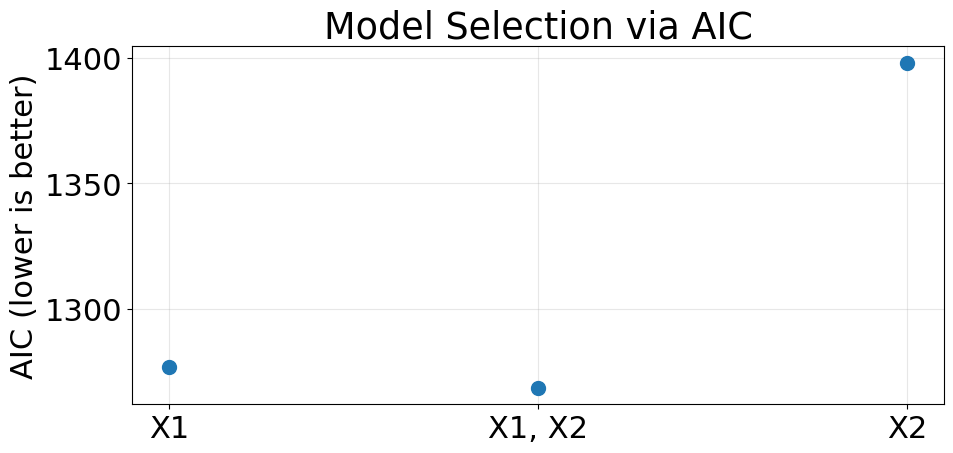

In [67]:
# Visualize AIC scores as dot plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(results)), results_df['AIC'], 'o', markersize=10)
plt.xticks(range(len(results)), results_df['features'])
plt.ylabel('AIC (lower is better)')
plt.title('Model Selection via AIC')
plt.grid(True, alpha=0.3)
plt.rcParams.update({'font.size': 22})
plt.xticks(range(len(results)), results_df['features'], fontsize=22)
plt.tight_layout()
plt.show()